In [1]:
## for data
import json
import pandas as pd
import numpy as np
## for plotting
import matplotlib.pyplot as plt
import seaborn as sns
## for processing
import re
import nltk
## for bag-of-words
from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing
## for explainer
# from lime import lime_text
## for word embedding
import gensim
import gensim.downloader as gensim_api
## for deep learning
from tensorflow.keras import models, layers, preprocessing as kprocessing
from tensorflow.keras import backend as K
## for bert language model
import transformers
import pickle
import pandas as pd

/Users/weijiesun/anaconda3/envs/zdwenv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/weijiesun/anaconda3/envs/zdwenv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/weijiesun/anaconda3/envs/zdwenv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/weijiesun/anaconda3/envs/zd

In [3]:
with open('./source/annotation_data.pickle', 'rb') as handle:
    annotation_data = pickle.load(handle)

In [4]:
data = {
    'Y': [],
    'X': [],
    'domain': []
}
for list_item in annotation_data:
    data['domain'].append(list_item[0])
    data['Y'].append(list_item[1])
    l = list_item[2].values
    flat_list = [str(item) for sublist in l for item in sublist]
    columns = list(list_item[2].columns)
    columns = [str(item) for item in columns]
    data['X'].append(' '.join(flat_list) + ' '.join(columns))
    

In [22]:
dtf = pd.DataFrame.from_dict(data)

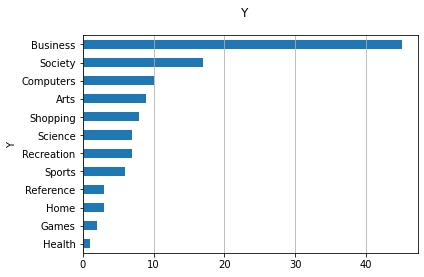

In [7]:
fig, ax = plt.subplots()
fig.suptitle("Y", fontsize=12)
dtf["Y"].reset_index().groupby("Y").count().sort_values(by= 
       "index").plot(kind="barh", legend=False, 
        ax=ax).grid(axis='x')
plt.show()

In [23]:
dtf = dtf[dtf['Y'].isin(['Business', 'Society', 'Computers', 'Arts', 'Shopping'])]
dtf

,Y,X,domain
0,Arts,Paintballs Valken Kilo Cal .50 4000 Und)*Envío...,www.tiendapaintball.com
1,Arts,1.0 BOTTLE O RING 2.0 PROTECCION CUELLO 3.0 SA...,www.tiendapaintball.com
2,Business,nan nan nan nan nan nan 1.0 2.0 3.0 4.0 5.0 6....,www.paragleiter.com
3,Computers,Timestamps (Monitoring Mode) No Yes Available ...,www.232analyzer.com
4,Computers,nan nan nan nan Programmable Buttons (1) Progr...,www.232analyzer.com
...,...,...,...
112,Society,65 and up $13 Under one year Free Group Rate $...,www.licm.org
114,Shopping,Liste des publications Publications sur Intern...,www.gboss.ca
115,Society,HeinOnline Lexis+* Lexis Digital Library (Stud...,library.law.hawaii.edu
116,Shopping,Currently Active Users: 96 (2 members and 94 g...,www.jobforum.ca


In [24]:
'''
Preprocess a string.
:parameter
    :param text: string - name of column containing text
    :param lst_stopwords: list - list of stopwords to remove
    :param flg_stemm: bool - whether stemming is to be applied
    :param flg_lemm: bool - whether lemmitisation is to be applied
:return
    cleaned text
'''
def utils_preprocess_text(text, flg_stemm=False, flg_lemm=True, lst_stopwords=None):
    ## clean (convert to lowercase and remove punctuations and characters and then strip)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
            
    ## Tokenize (convert from string to list)
    lst_text = text.split()
    ## remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in 
                    lst_stopwords]
                
    ## Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
                
    ## Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
            
    ## back to string from list
    text = " ".join(lst_text)
    return text

In [10]:
# import nltk
# nltk.download('stopwords')
# nltk.download('wordnet')

In [25]:
lst_stopwords = nltk.corpus.stopwords.words("english")
# lst_stopwords

In [26]:
dtf["text_clean"] = dtf["X"].apply(lambda x: 
          utils_preprocess_text(x, flg_stemm=False, flg_lemm=True, 
          lst_stopwords=lst_stopwords))
dtf.head()

,Y,X,domain,text_clean
0,Arts,Paintballs Valken Kilo Cal .50 4000 Und)*Envío...,www.tiendapaintball.com,paintball valken kilo cal 50 4000 undenvío gra...
1,Arts,1.0 BOTTLE O RING 2.0 PROTECCION CUELLO 3.0 SA...,www.tiendapaintball.com,10 bottle ring 20 proteccion cuello 30 saco de...
2,Business,nan nan nan nan nan nan 1.0 2.0 3.0 4.0 5.0 6....,www.paragleiter.com,nan nan nan nan nan nan 10 20 30 40 50 60 70 8...
3,Computers,Timestamps (Monitoring Mode) No Yes Available ...,www.232analyzer.com,timestamps monitoring mode yes available data ...
4,Computers,nan nan nan nan Programmable Buttons (1) Progr...,www.232analyzer.com,nan nan nan nan programmable button 1 programm...


In [27]:
## split dataset
dtf_train, dtf_test = model_selection.train_test_split(dtf, test_size=0.3)
## get target
y_train = dtf_train["Y"].values
y_test = dtf_test["Y"].values

In [28]:
## Count (classic BoW)
vectorizer = feature_extraction.text.CountVectorizer(max_features=10000, ngram_range=(1,2))

## Tf-Idf (advanced variant of BoW)
vectorizer = feature_extraction.text.TfidfVectorizer(max_features=10000, ngram_range=(1,2))

In [29]:
corpus = dtf_train["text_clean"]
vectorizer.fit(corpus)
X_train = vectorizer.transform(corpus)
dic_vocabulary = vectorizer.vocabulary_

In [30]:
from sklearn import feature_selection 

In [31]:
y = dtf_train["Y"]
X_names = vectorizer.get_feature_names()
p_value_limit = 0.95
dtf_features = pd.DataFrame()
for cat in np.unique(y):
    chi2, p = feature_selection.chi2(X_train, y==cat)
    dtf_features = dtf_features.append(pd.DataFrame(
                   {"feature":X_names, "score":1-p, "y":cat}))
    dtf_features = dtf_features.sort_values(["y","score"], 
                    ascending=[True,False])
    dtf_features = dtf_features[dtf_features["score"]>p_value_limit]
X_names = dtf_features["feature"].unique().tolist()

In [32]:
for cat in np.unique(y):
   print("# {}:".format(cat))
   print("  . selected features:",
         len(dtf_features[dtf_features["y"]==cat]))
   print("  . top features:", ",".join(
dtf_features[dtf_features["y"]==cat]["feature"].values[:10]))
   print(" ")

# Arts:
  . selected features: 3
  . top features: aviation,chalair,chalair aviation
 
# Business:
  . selected features: 0
  . top features: 
 
# Computers:
  . selected features: 1
  . top features: yes
 
# Shopping:
  . selected features: 0
  . top features: 
 
# Society:
  . selected features: 0
  . top features: 
 


In [33]:
vectorizer = feature_extraction.text.TfidfVectorizer(vocabulary=X_names)
vectorizer.fit(corpus)
X_train = vectorizer.transform(corpus)
dic_vocabulary = vectorizer.vocabulary_

In [34]:
classifier = naive_bayes.MultinomialNB()

In [35]:
## pipeline
model = pipeline.Pipeline([("vectorizer", vectorizer),  
                           ("classifier", classifier)])
## train classifier
model["classifier"].fit(X_train, y_train)
## test
X_test = dtf_test["text_clean"].values
predicted = model.predict(X_test)
predicted_prob = model.predict_proba(X_test)

In [38]:
# predicted

Accuracy: 0.59
Auc: 0.5
Detail:
              precision    recall  f1-score   support

        Arts       0.00      0.00      0.00         2
    Business       0.59      1.00      0.74        16
   Computers       0.00      0.00      0.00         2
    Shopping       0.00      0.00      0.00         1
     Society       0.00      0.00      0.00         6

    accuracy                           0.59        27
   macro avg       0.12      0.20      0.15        27
weighted avg       0.35      0.59      0.44        27



/Users/weijiesun/anaconda3/envs/zdwenv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


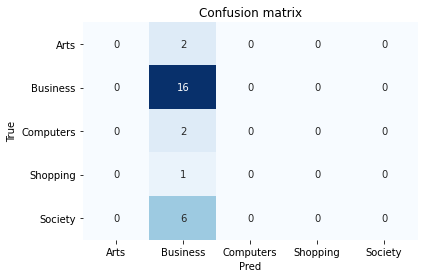

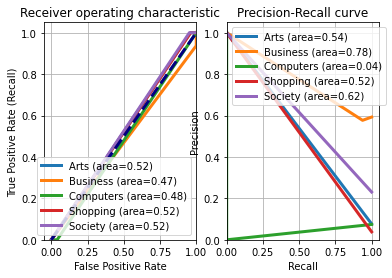

In [36]:
from sklearn import metrics 

classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values
    
## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(list(y_test), list(predicted))
auc = metrics.roc_auc_score(y_test_array, predicted_prob, multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted))
    
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test, predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2)
## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()